In [3]:
import numpy as np
from trace_IO import *
from TraceSimulator import TraceSimulator
import matplotlib.pyplot as plt
from OptimumFilter import *


In [3]:
sampling_frequency = 3906250

noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")


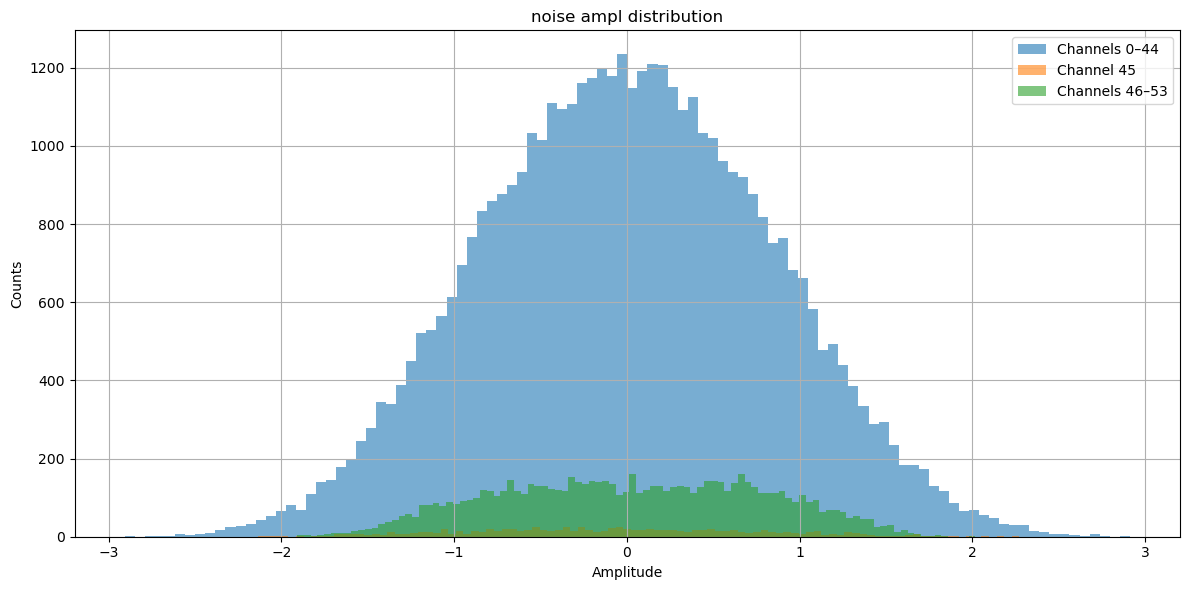

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# loaded_traces should be shape (1000, 54, trace_length)
n_events = len(loaded_traces)
amps_all = np.zeros((n_events, 54))
chisqs_all = np.zeros((n_events, 54))

for i in range(n_events):
    traces = loaded_traces[i]
    for ch in range(54):
        if ch <= 44:
            amp, chisq = trigger_1.fit(traces[ch])
        elif ch == 45:
            amp, chisq = trigger_2.fit(traces[ch])
        else:
            amp, chisq = trigger_3.fit(traces[ch])

        amps_all[i, ch] = amp
        chisqs_all[i, ch] = chisq

# Group amplitude data by channel ranges
amps_sub = amps_all[:, :45].flatten()     # Channels 0–44
amps_45 = amps_all[:, 45]
amps_46plus = amps_all[:, 46:].flatten()  # Channels 46–53

# Plot histograms
plt.figure(figsize=(12, 6))

plt.hist(amps_sub, bins=100, alpha=0.6, label='Channels 0–44')
plt.hist(amps_45, bins=100, alpha=0.6, label='Channel 45')
plt.hist(amps_46plus, bins=100, alpha=0.6, label='Channels 46–53')

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.title('noise ampl distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
print("Amplitude stats:")
print(f"Ch 0–44:    mean = {np.mean(amps_sub):.3f}, std = {np.std(amps_sub):.3f}")
print(f"Ch 45:      mean = {np.mean(amps_45):.3f}, std = {np.std(amps_45):.3f}")
print(f"Ch 46–53:   mean = {np.mean(amps_46plus):.3f}, std = {np.std(amps_46plus):.3f}")

Amplitude stats:
Ch 0–44:    mean = -0.002, std = 0.832
Ch 45:      mean = -0.068, std = 0.843
Ch 46–53:   mean = 0.017, std = 0.761


In [18]:
print("Amplitude stats:")
print(f"Ch 0–44:    mean = {np.mean(amps_sub):.3f}, std = {np.std(amps_sub):.3f}")
print(f"Ch 45:      mean = {np.mean(amps_45):.3f}, std = {np.std(amps_45):.3f}")
print(f"Ch 46–53:   mean = {np.mean(amps_46plus):.3f}, std = {np.std(amps_46plus):.3f}")


Amplitude stats:
Ch 0–44:    mean = -0.002, std = 0.832
Ch 45:      mean = -0.068, std = 0.844
Ch 46–53:   mean = 0.017, std = 0.761


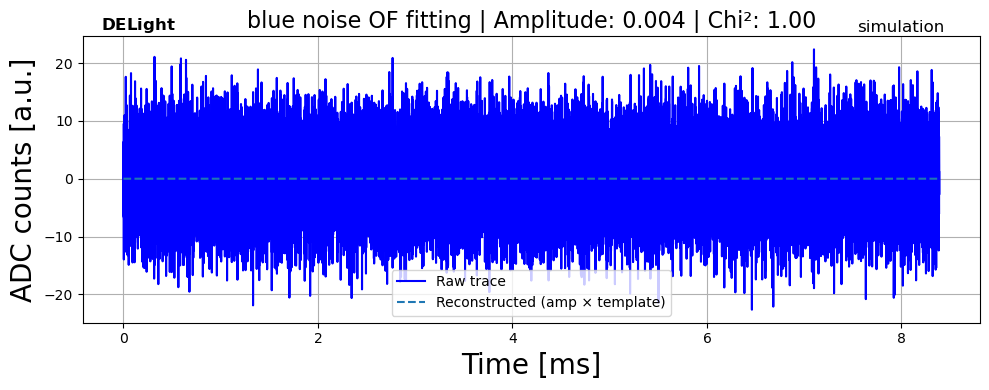

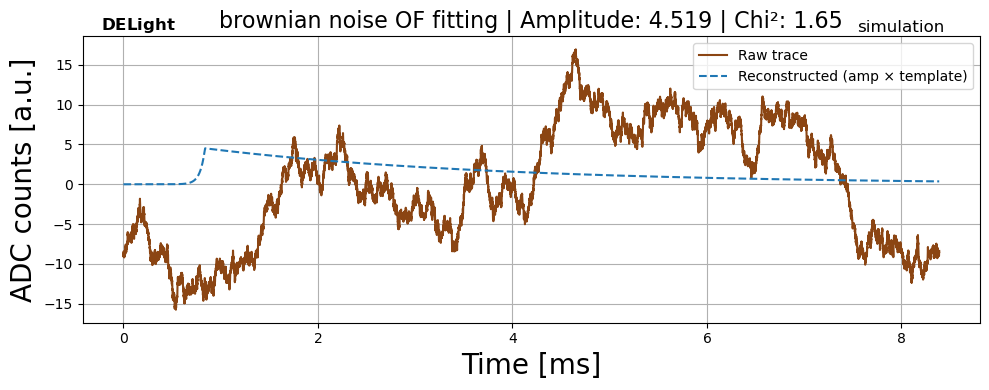

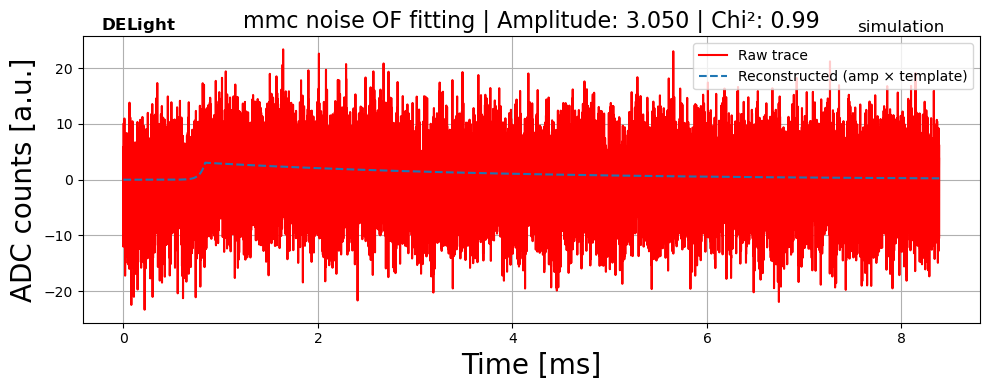

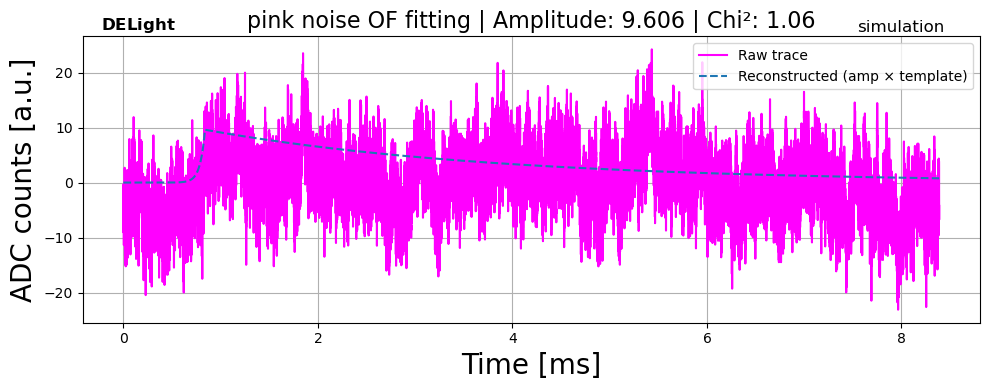

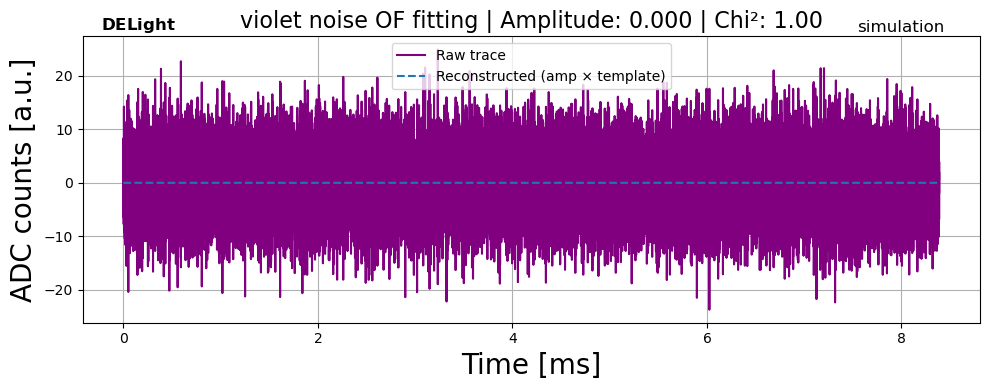

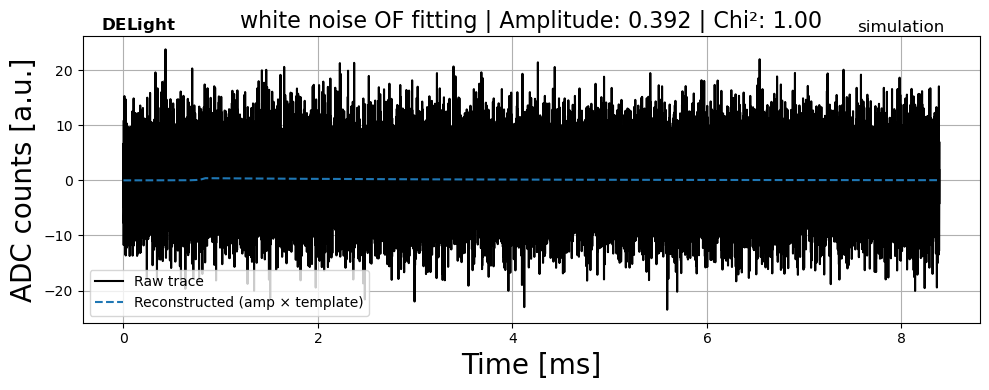

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OptimumFilter(template, mmc_psd, sampling_frequency)
brownian_trigger = OptimumFilter(template, brownian_psd, sampling_frequency)
white_trigger = OptimumFilter(template, white_psd, sampling_frequency)
blue_trigger = OptimumFilter(template, blue_psd, sampling_frequency)
pink_trigger = OptimumFilter(template, pink_psd, sampling_frequency)
violet_trigger = OptimumFilter(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping for raw traces
color_map = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'red',  # Default/fallback color
}

# Function to process a noise file
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    max_amp = -np.inf
    best_trace = None
    best_template = template
    best_ch = -1
    best_idx = -1
    best_chisq = None

    for trace_idx, trace_set in enumerate(traces):  # 100 sets
        for ch in range(54):  # 54 channels
            amp, chisq = trigger.fit(trace_set[ch])
            if amp > max_amp:
                max_amp = amp
                best_trace = trace_set[ch]
                best_ch = ch
                best_idx = trace_idx
                best_chisq = chisq

    # Plot the best trace
    color = color_map.get(label.lower(), 'gray')
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(time_axis, best_trace, label='Raw trace', color=color)
    ax.plot(time_axis, max_amp * best_template, label='Reconstructed (amp × template)', linestyle='--')
    ax.set_title(f'{label} noise OF fitting | Amplitude: {max_amp:.3f} | Chi²: {best_chisq:.2f}', fontsize = 16)
    ax.set_xlabel('Time [ms]', fontsize = 20)
    ax.set_ylabel('ADC counts [a.u.]', fontsize = 20)
    ax.legend()
    ax.grid(True)

    # Add plain text labels (top-left and top-right)
    ax.text(0.02, 1.0045, r'$\mathbf{DELight}$', transform=ax.transAxes, fontsize=12, va='bottom', ha='left')
    ax.text(0.96, 1.004, "simulation", transform=ax.transAxes, fontsize=12, va='bottom', ha='right')

    plt.tight_layout()
    plt.show()


# Define directory and file names
noise_dir = "/ceph/dwong/trigger_samples/noise_traces_w_o_quanization"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Loop through all noise types
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    process_noise_file(full_path, label)


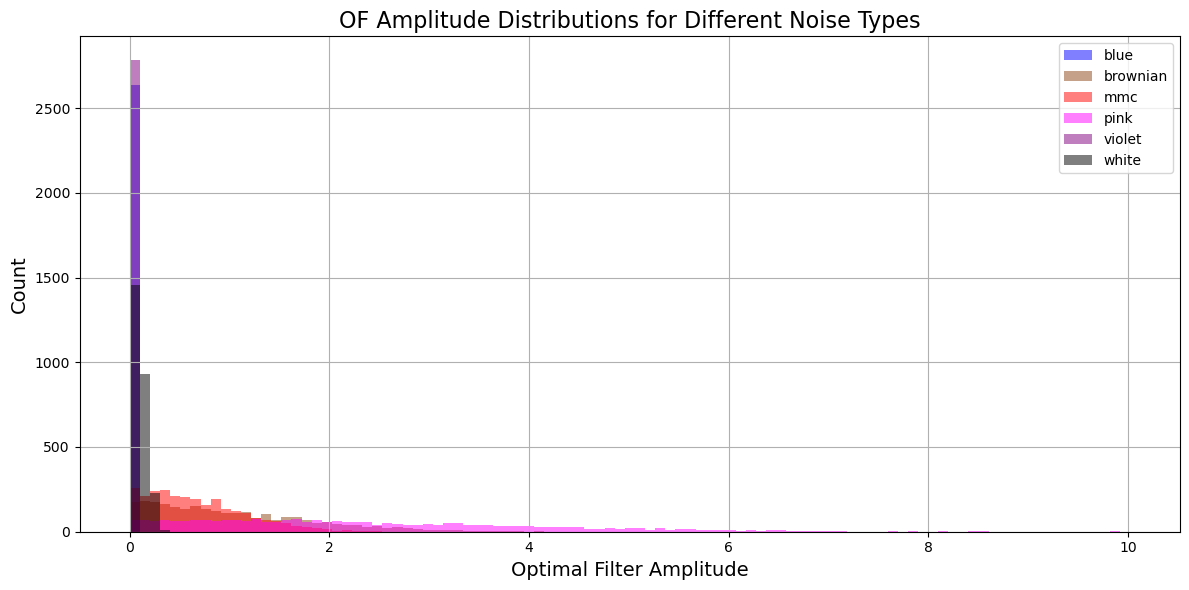

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OptimumFilter(template, mmc_psd, sampling_frequency)
brownian_trigger = OptimumFilter(template, brownian_psd, sampling_frequency)
white_trigger = OptimumFilter(template, white_psd, sampling_frequency)
blue_trigger = OptimumFilter(template, blue_psd, sampling_frequency)
pink_trigger = OptimumFilter(template, pink_psd, sampling_frequency)
violet_trigger = OptimumFilter(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping
color_map = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'red',
}

# Process and collect amplitude statistics
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    amplitudes = []
    max_amp = -np.inf
    best_trace = None
    best_idx = -1
    best_ch = -1
    best_chisq = None

    for trace_idx, trace_set in enumerate(traces):
        for ch in range(54):
            amp, chisq = trigger.fit(trace_set[ch])
            amplitudes.append(amp)
    return amplitudes


# Define noise files
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Collect amplitudes for all noise types
all_amplitudes = {}

for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    amplitudes = process_noise_file(full_path, label)
    all_amplitudes[label] = amplitudes

# Plot histogram
plt.figure(figsize=(12, 6))
bins = np.linspace(0, max(max(amps) for amps in all_amplitudes.values()), 100)

for label, amps in all_amplitudes.items():
    plt.hist(amps, bins=bins, alpha=0.5, label=label, color=color_map.get(label, 'gray'))

plt.title("OF Amplitude Distributions for Different Noise Types", fontsize=16)
plt.xlabel("Optimal Filter Amplitude", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


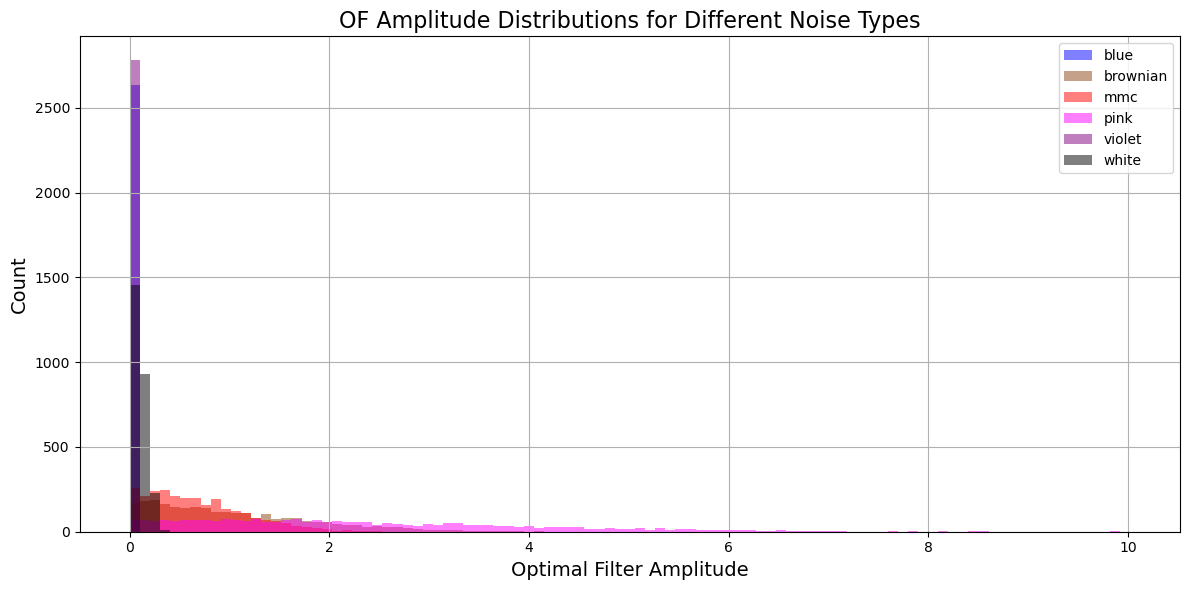

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from OF import *

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OFtrigger(template, mmc_psd, sampling_frequency)
brownian_trigger = OFtrigger(template, brownian_psd, sampling_frequency)
white_trigger = OFtrigger(template, white_psd, sampling_frequency)
blue_trigger = OFtrigger(template, blue_psd, sampling_frequency)
pink_trigger = OFtrigger(template, pink_psd, sampling_frequency)
violet_trigger = OFtrigger(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping
color_map = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'red',
}

# Process and collect amplitude statistics
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    amplitudes = []
    max_amp = -np.inf
    best_trace = None
    best_idx = -1
    best_ch = -1
    best_chisq = None

    for trace_idx, trace_set in enumerate(traces):
        for ch in range(54):
            amp, chisq = trigger.fit(trace_set[ch])
            amplitudes.append(amp)
    return amplitudes


# Define noise files
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Collect amplitudes for all noise types
all_amplitudes = {}

for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    amplitudes = process_noise_file(full_path, label)
    all_amplitudes[label] = amplitudes

# Plot histogram
plt.figure(figsize=(12, 6))
bins = np.linspace(0, max(max(amps) for amps in all_amplitudes.values()), 100)

for label, amps in all_amplitudes.items():
    plt.hist(amps, bins=bins, alpha=0.5, label=label, color=color_map.get(label, 'gray'))

plt.title("OF Amplitude Distributions for Different Noise Types", fontsize=16)
plt.xlabel("Optimal Filter Amplitude", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Processing noise files...
Processing blue...
Processing brownian...
Processing mmc...
Processing pink...
Processing violet...
Processing white...


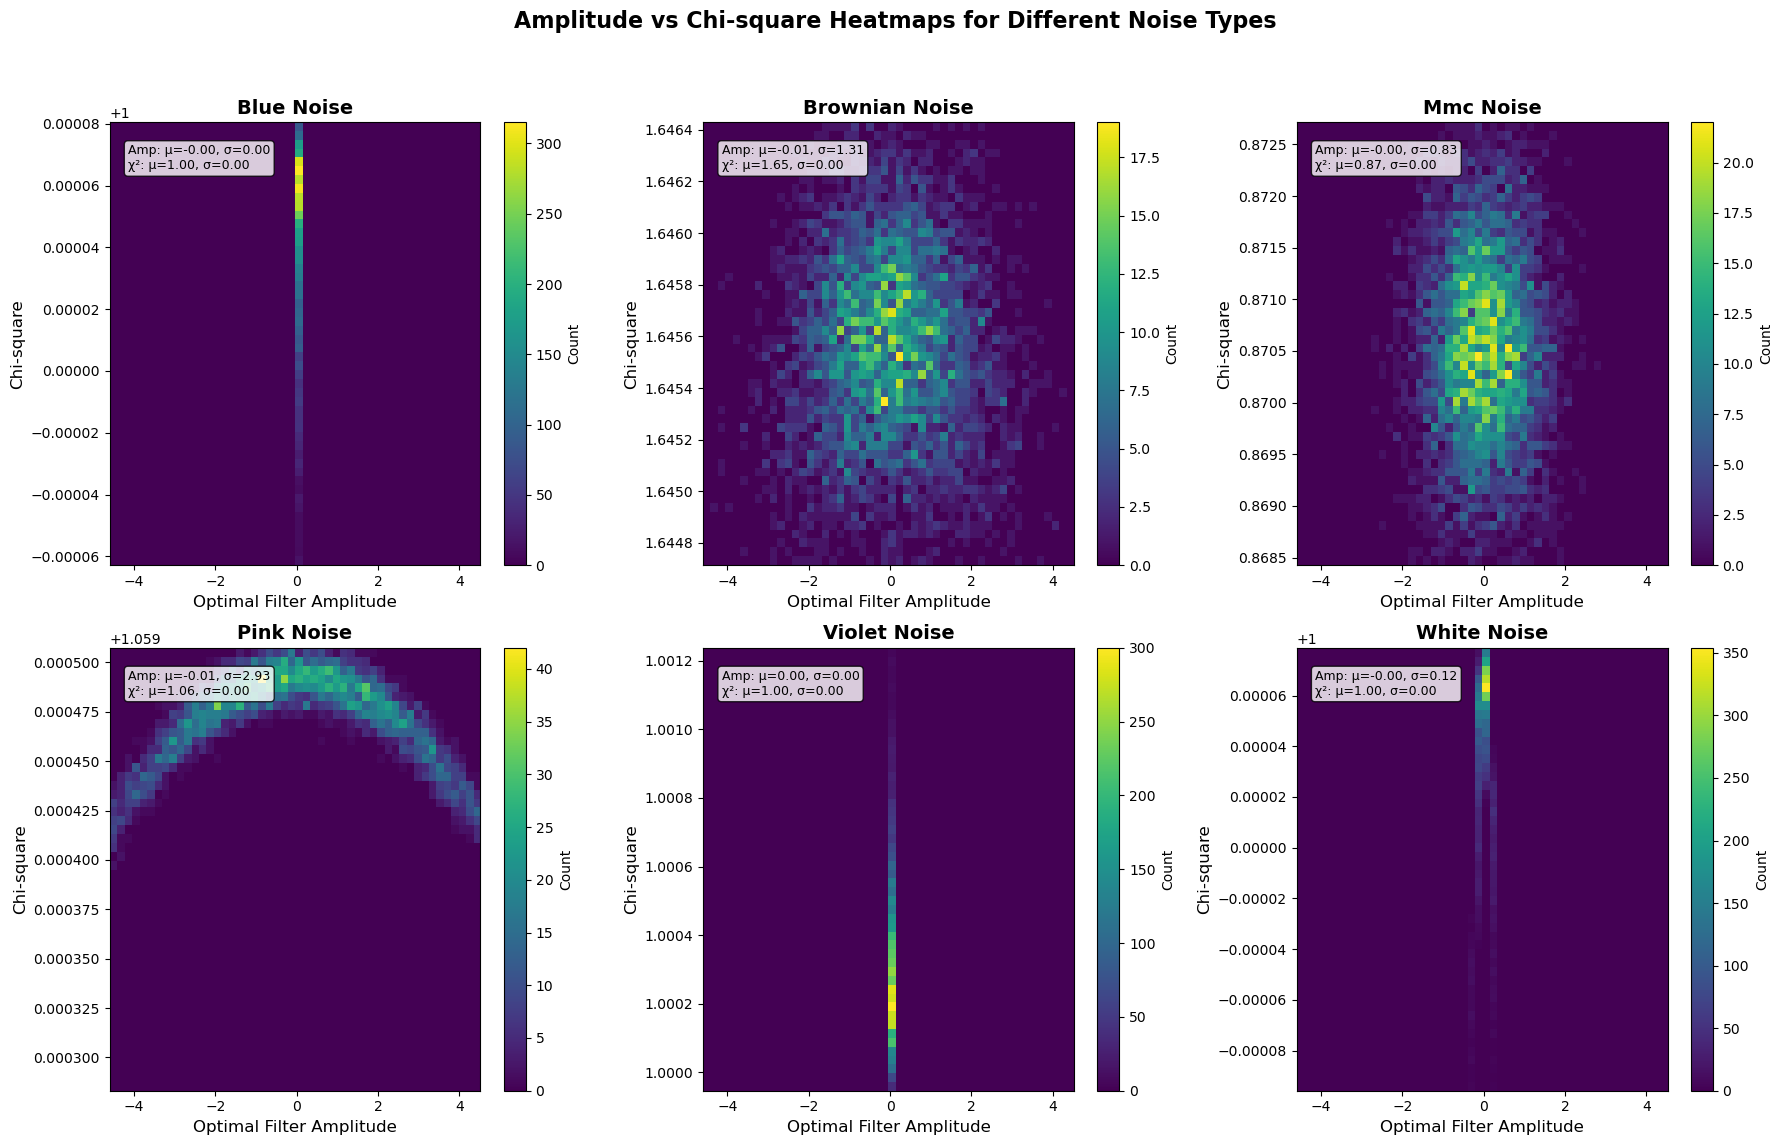


SUMMARY STATISTICS
Noise Type   Amp Mean   Amp Std    χ² Mean    χ² Std     N Points  
--------------------------------------------------------------------------------
blue         -0.000     0.002      1.000      0.000      5400      
brownian     -0.009     1.310      1.646      0.000      5400      
mmc          -0.002     0.827      0.871      0.001      5400      
pink         -0.006     2.934      1.059      0.000      5400      
violet       0.000      0.000      1.000      0.000      5400      
white        -0.003     0.121      1.000      0.000      5400      


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OptimumFilter(template, mmc_psd, sampling_frequency)
brownian_trigger = OptimumFilter(template, brownian_psd, sampling_frequency)
white_trigger = OptimumFilter(template, white_psd, sampling_frequency)
blue_trigger = OptimumFilter(template, blue_psd, sampling_frequency)
pink_trigger = OptimumFilter(template, pink_psd, sampling_frequency)
violet_trigger = OptimumFilter(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping - using same colormap for both heatmaps and scatter plots
color_map = {
    'white': 'Greys',
    'pink': 'Reds',
    'brownian': 'copper',
    'blue': 'Blues',
    'violet': 'Purples',
    'mmc': 'Reds',
}

# Process and collect amplitude and chi-square statistics
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    amplitudes = []
    chisquares = []

    for trace_idx, trace_set in enumerate(traces):
        for ch in range(54):
            amp, chisq = trigger.fit(trace_set[ch])
            amplitudes.append(amp)
            chisquares.append(chisq)
    
    return np.array(amplitudes), np.array(chisquares)

# Define noise files
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Collect amplitudes and chi-squares for all noise types
all_data = {}

print("Processing noise files...")
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    print(f"Processing {label}...")
    amplitudes, chisquares = process_noise_file(full_path, label)
    all_data[label] = {'amplitudes': amplitudes, 'chisquares': chisquares}

# Create heatmaps - one plot for each noise type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Find global x-range for consistent amplitude scaling
all_amps = np.concatenate([data['amplitudes'] for data in all_data.values()])
amp_range = [np.percentile(all_amps, 1), np.percentile(all_amps, 99)]

for idx, (label, data) in enumerate(all_data.items()):
    ax = axes[idx]
    amplitudes = data['amplitudes']
    chisquares = data['chisquares']
    
    # Individual y-range for each subplot (zoomed in)
    chisq_range = [np.percentile(chisquares, 1), np.percentile(chisquares, 99)]
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(amplitudes, chisquares, 
                                         bins=50, 
                                         range=[amp_range, chisq_range])
    
    # Plot heatmap using 'viridis' colormap for all
    im = ax.imshow(hist.T, origin='lower', aspect='auto', 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
    
    ax.set_title(f'{label.capitalize()} Noise', fontsize=14, fontweight='bold')
    ax.set_xlabel('Optimal Filter Amplitude', fontsize=12)
    ax.set_ylabel('Chi-square', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', fontsize=10)
    
    # Add statistics text
    mean_amp = np.mean(amplitudes)
    std_amp = np.std(amplitudes)
    mean_chisq = np.mean(chisquares)
    std_chisq = np.std(chisquares)
    
    stats_text = f'Amp: μ={mean_amp:.2f}, σ={std_amp:.2f}\nχ²: μ={mean_chisq:.2f}, σ={std_chisq:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)

plt.suptitle('Amplitude vs Chi-square Heatmaps for Different Noise Types', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"{'Noise Type':<12} {'Amp Mean':<10} {'Amp Std':<10} {'χ² Mean':<10} {'χ² Std':<10} {'N Points':<10}")
print("-"*80)

for label, data in all_data.items():
    amp_mean = np.mean(data['amplitudes'])
    amp_std = np.std(data['amplitudes'])
    chisq_mean = np.mean(data['chisquares'])
    chisq_std = np.std(data['chisquares'])
    n_points = len(data['amplitudes'])
    
    print(f"{label:<12} {amp_mean:<10.3f} {amp_std:<10.3f} {chisq_mean:<10.3f} {chisq_std:<10.3f} {n_points:<10}")

Processing noise files...
Processing blue...
Processing brownian...
Processing mmc...
Processing pink...
Processing violet...
Processing white...


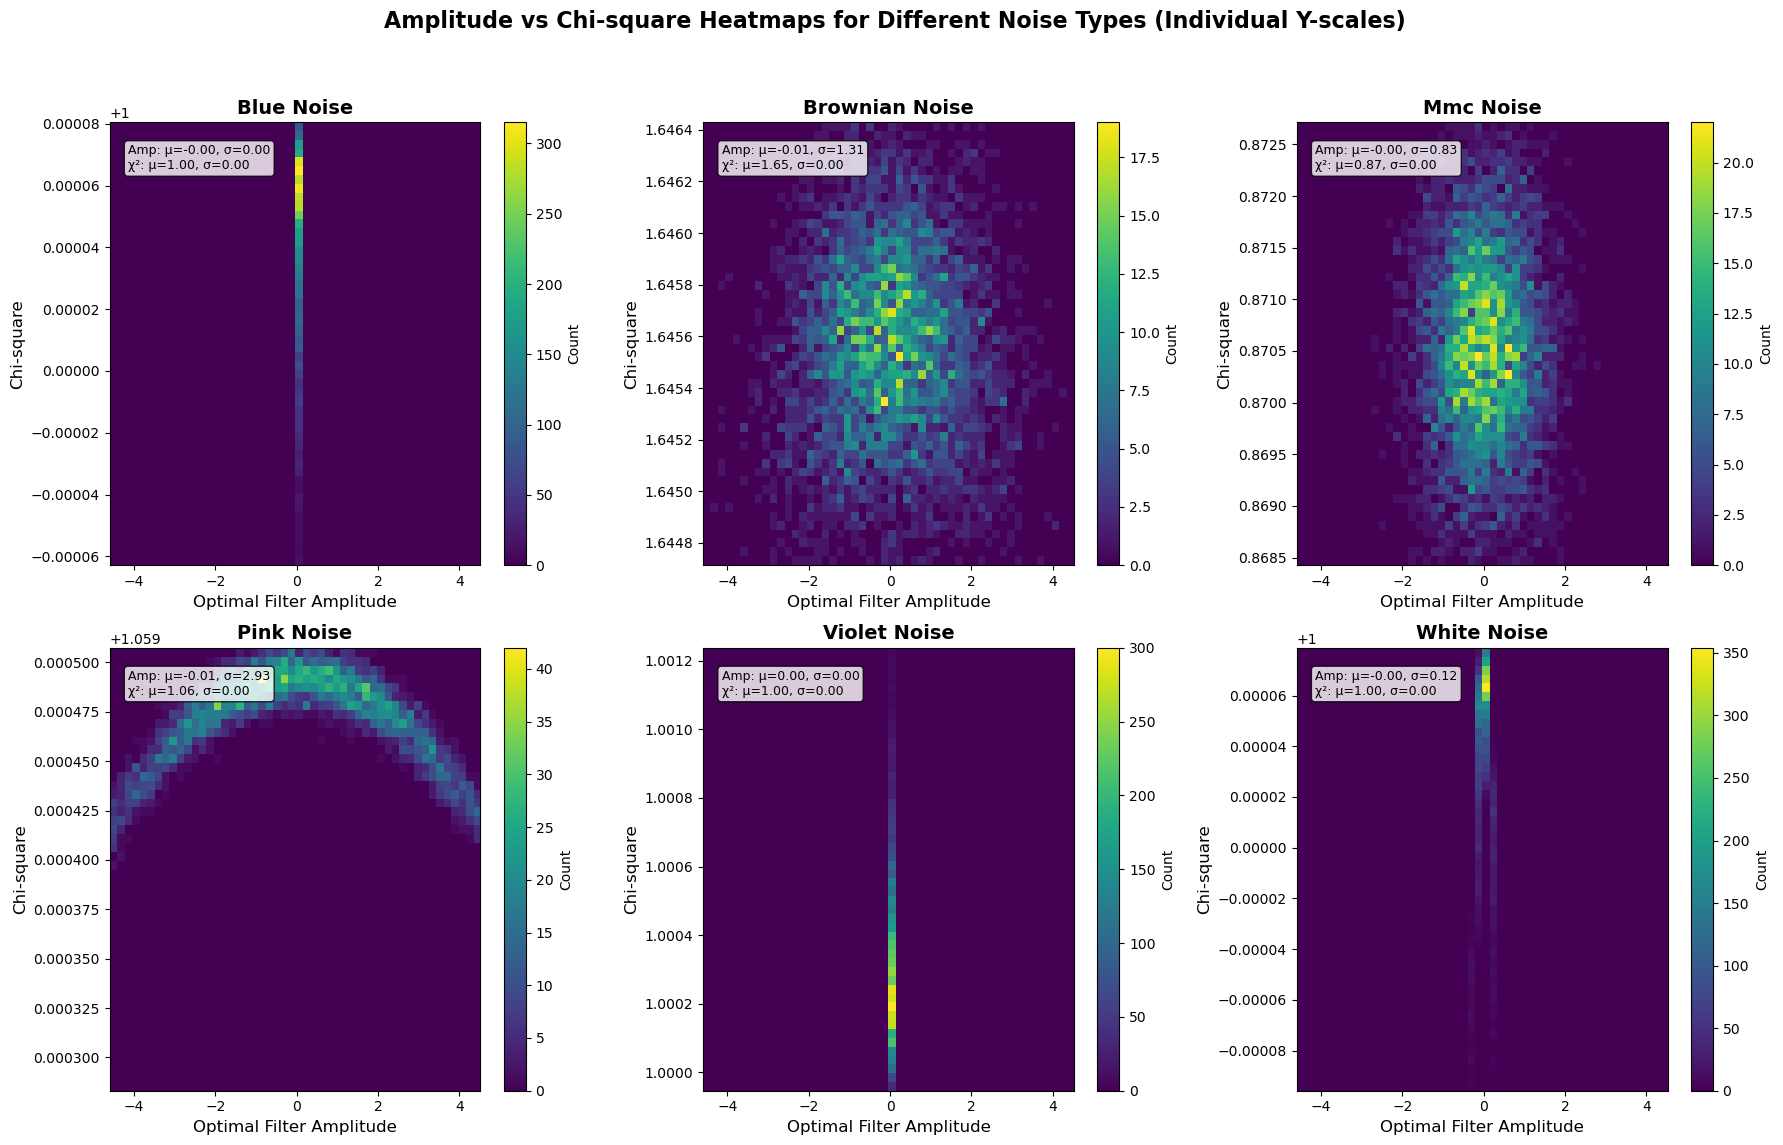

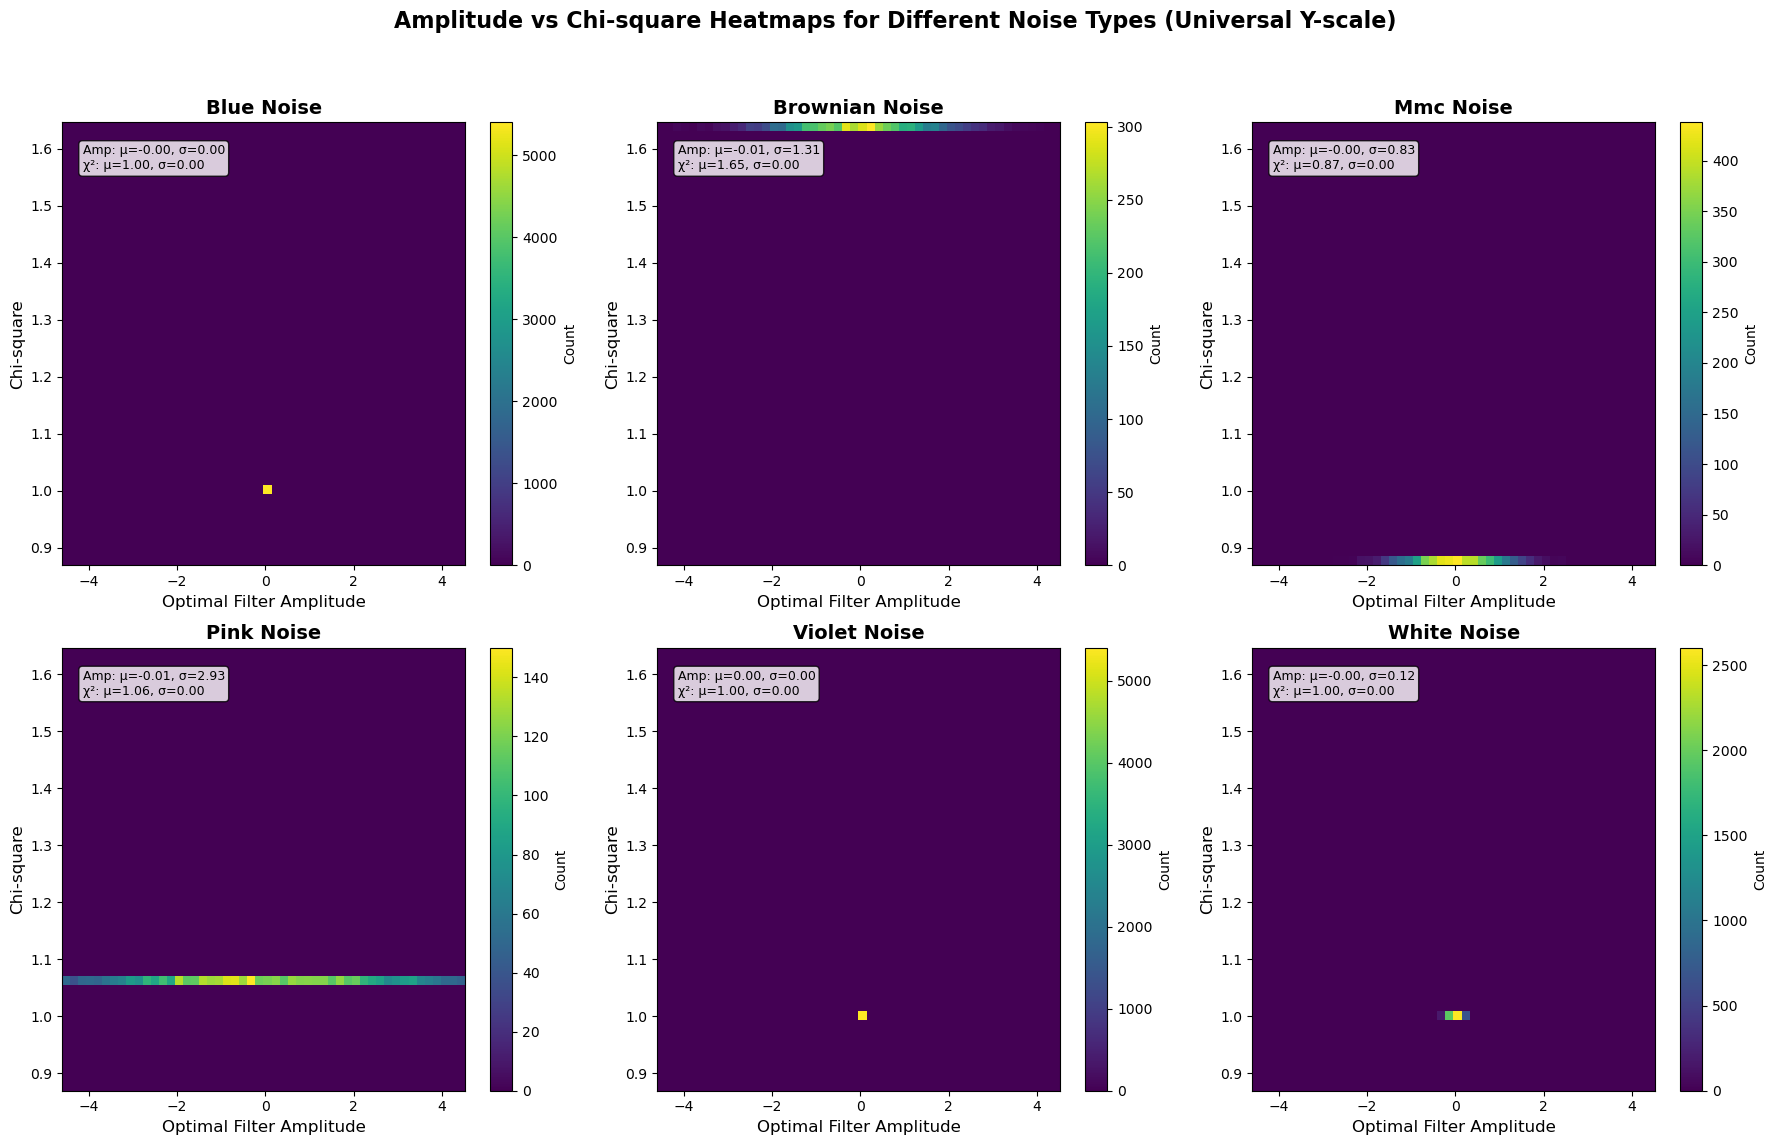


SUMMARY STATISTICS
Noise Type   Amp Mean   Amp Std    χ² Mean    χ² Std     N Points  
--------------------------------------------------------------------------------
blue         -0.000     0.002      1.000      0.000      5400      
brownian     -0.009     1.310      1.646      0.000      5400      
mmc          -0.002     0.827      0.871      0.001      5400      
pink         -0.006     2.934      1.059      0.000      5400      
violet       0.000      0.000      1.000      0.000      5400      
white        -0.003     0.121      1.000      0.000      5400      


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OptimumFilter(template, mmc_psd, sampling_frequency)
brownian_trigger = OptimumFilter(template, brownian_psd, sampling_frequency)
white_trigger = OptimumFilter(template, white_psd, sampling_frequency)
blue_trigger = OptimumFilter(template, blue_psd, sampling_frequency)
pink_trigger = OptimumFilter(template, pink_psd, sampling_frequency)
violet_trigger = OptimumFilter(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping - using same colormap for both heatmaps and scatter plots
color_map = {
    'white': 'Greys',
    'pink': 'Reds',
    'brownian': 'copper',
    'blue': 'Blues',
    'violet': 'Purples',
    'mmc': 'Reds',
}

# Process and collect amplitude and chi-square statistics
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    amplitudes = []
    chisquares = []

    for trace_idx, trace_set in enumerate(traces):
        for ch in range(54):
            amp, chisq = trigger.fit(trace_set[ch])
            amplitudes.append(amp)
            chisquares.append(chisq)
    
    return np.array(amplitudes), np.array(chisquares)

# Define noise files
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Collect amplitudes and chi-squares for all noise types
all_data = {}

print("Processing noise files...")
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    print(f"Processing {label}...")
    amplitudes, chisquares = process_noise_file(full_path, label)
    all_data[label] = {'amplitudes': amplitudes, 'chisquares': chisquares}

# Create heatmaps - one plot for each noise type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Find global x-range for consistent amplitude scaling
all_amps = np.concatenate([data['amplitudes'] for data in all_data.values()])
amp_range = [np.percentile(all_amps, 1), np.percentile(all_amps, 99)]

for idx, (label, data) in enumerate(all_data.items()):
    ax = axes[idx]
    amplitudes = data['amplitudes']
    chisquares = data['chisquares']
    
    # Individual y-range for each subplot (zoomed in)
    chisq_range = [np.percentile(chisquares, 1), np.percentile(chisquares, 99)]
    
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(amplitudes, chisquares, 
                                         bins=50, 
                                         range=[amp_range, chisq_range])
    
    # Plot heatmap using 'viridis' colormap for all
    im = ax.imshow(hist.T, origin='lower', aspect='auto', 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
    
    ax.set_title(f'{label.capitalize()} Noise', fontsize=14, fontweight='bold')
    ax.set_xlabel('Optimal Filter Amplitude', fontsize=12)
    ax.set_ylabel('Chi-square', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', fontsize=10)
    
    # Add statistics text
    mean_amp = np.mean(amplitudes)
    std_amp = np.std(amplitudes)
    mean_chisq = np.mean(chisquares)
    std_chisq = np.std(chisquares)
    
    stats_text = f'Amp: μ={mean_amp:.2f}, σ={std_amp:.2f}\nχ²: μ={mean_chisq:.2f}, σ={std_chisq:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)

plt.suptitle('Amplitude vs Chi-square Heatmaps for Different Noise Types (Individual Y-scales)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Create second figure with universal y-scale
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Find global ranges for consistent scaling
all_chisqs = np.concatenate([data['chisquares'] for data in all_data.values()])
chisq_range_global = [np.percentile(all_chisqs, 1), np.percentile(all_chisqs, 99)]

for idx, (label, data) in enumerate(all_data.items()):
    ax = axes[idx]
    amplitudes = data['amplitudes']
    chisquares = data['chisquares']
    
    # Create 2D histogram with global y-range
    hist, xedges, yedges = np.histogram2d(amplitudes, chisquares, 
                                         bins=50, 
                                         range=[amp_range, chisq_range_global])
    
    # Plot heatmap using 'viridis' colormap for all
    im = ax.imshow(hist.T, origin='lower', aspect='auto', 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='viridis')
    
    ax.set_title(f'{label.capitalize()} Noise', fontsize=14, fontweight='bold')
    ax.set_xlabel('Optimal Filter Amplitude', fontsize=12)
    ax.set_ylabel('Chi-square', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', fontsize=10)
    
    # Add statistics text
    mean_amp = np.mean(amplitudes)
    std_amp = np.std(amplitudes)
    mean_chisq = np.mean(chisquares)
    std_chisq = np.std(chisquares)
    
    stats_text = f'Amp: μ={mean_amp:.2f}, σ={std_amp:.2f}\nχ²: μ={mean_chisq:.2f}, σ={std_chisq:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)

plt.suptitle('Amplitude vs Chi-square Heatmaps for Different Noise Types (Universal Y-scale)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"{'Noise Type':<12} {'Amp Mean':<10} {'Amp Std':<10} {'χ² Mean':<10} {'χ² Std':<10} {'N Points':<10}")
print("-"*80)

for label, data in all_data.items():
    amp_mean = np.mean(data['amplitudes'])
    amp_std = np.std(data['amplitudes'])
    chisq_mean = np.mean(data['chisquares'])
    chisq_std = np.std(data['chisquares'])
    n_points = len(data['amplitudes'])
    
    print(f"{label:<12} {amp_mean:<10.3f} {amp_std:<10.3f} {chisq_mean:<10.3f} {chisq_std:<10.3f} {n_points:<10}")